## Accelerate Inference: Neural Network Pruning

In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.9.2


In [12]:
# untar
!tar -xvzf dataset.tar.gz

# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))

# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


# Training
BatchNorm is used initially to calculate channel scaling factors. BatchNorm dropped during pruning.

In [13]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization(center=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

In [14]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 25, 25, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_12 (Activation)  (None, 25, 25, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 23, 23, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_13 (Activation)  (None, 23, 23, 32)       

In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=50,
                    validation_data=(val_images, val_labels))

Epoch 1/50
703/703 [==============================] - 5s 6ms/step - loss: 1.6523 - accuracy: 0.3164 - val_loss: 1.3906 - val_accuracy: 0.4158
Epoch 2/50
703/703 [==============================] - 4s 5ms/step - loss: 1.3860 - accuracy: 0.4060 - val_loss: 1.2754 - val_accuracy: 0.4681
Epoch 3/50
703/703 [==============================] - 4s 5ms/step - loss: 1.3105 - accuracy: 0.4457 - val_loss: 1.2218 - val_accuracy: 0.4875
Epoch 4/50
703/703 [==============================] - 4s 6ms/step - loss: 1.2615 - accuracy: 0.4735 - val_loss: 1.1906 - val_accuracy: 0.4970
Epoch 5/50
703/703 [==============================] - 4s 6ms/step - loss: 1.2245 - accuracy: 0.4937 - val_loss: 1.2013 - val_accuracy: 0.4958
Epoch 6/50
703/703 [==============================] - 5s 7ms/step - loss: 1.1799 - accuracy: 0.5175 - val_loss: 1.1850 - val_accuracy: 0.5030
Epoch 7/50
703/703 [==============================] - 4s 6ms/step - loss: 1.1539 - accuracy: 0.5273 - val_loss: 1.0968 - val_accuracy: 0.5509
Epoch 

In [16]:
results = model.evaluate(val_images, val_labels, batch_size=128)

20/20 [==============================] - 0s 10ms/step - loss: 0.9147 - accuracy: 0.6717


In [17]:
model.save_weights('trained_model.h5')

# Pruning
Channel scaling factors are first calculated from model with BatchNorm (using BatchNorm scaling factor) and if they are less than the threshold value, they are set to zero considering the corresponding channels are unimportant. The channel to be dropped are kept fixed while retraining assuming that the unimportant channels remain the same with/without BathcNorm and during retraining as well.

In [18]:
def sparsity(weights):
 
    zero_weights = 0
  
    for i in range(len(weights)):
      
        curr_zero_weights = tf.reduce_sum((weights[i]==0)*1).numpy()
        zero_weights += curr_zero_weights

    return zero_weights / 592933

In [19]:
def get_nonbatchnorm_model(model):

    new_model = models.Sequential()

    for i, layer in enumerate(model.layers):
        if not isinstance(layer, keras.layers.BatchNormalization):
            new_model.add(layer)
    
    return new_model

In [20]:
all_thres = np.arange(0.92, 1.05, 0.01)
all_models = []
loops = 2

for thres in all_thres:

    print('\nthreshold', thres)

    model.load_weights('trained_model.h5')
    all_sparse_gamma = []

    for i, layer in enumerate(model.layers):
        if isinstance(layer, keras.layers.BatchNormalization):

            gamma = layer.get_weights()[0]
            sparse_gamma = (gamma > thres).astype(float)

            # save un/important channels
            all_sparse_gamma.append(sparse_gamma)

            conv_weight = model.layers[i-1].get_weights()[0]
            conv_bias = model.layers[i-1].get_weights()[1]

            conv_weight *= sparse_gamma
            conv_bias *= sparse_gamma

            model.layers[i-1].set_weights([conv_weight, conv_bias])

    pruned_model = get_nonbatchnorm_model(model)
    pruned_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001, decay=1e-6),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

    for i in tqdm(range(loops), total=loops):

        history = pruned_model.fit(train_images, train_labels, batch_size=32, epochs=2,
                                  validation_data=(val_images, val_labels))

        # drop/keep convolution layer channel weights
        conv_count = 0

        for i, layer in enumerate(pruned_model.layers):
            if isinstance(layer, keras.layers.Conv2D):

                sparse_gamma = all_sparse_gamma[conv_count]
                conv_count += 1

                conv_weight = layer.get_weights()[0]
                conv_bias = layer.get_weights()[1]

                conv_weight *= sparse_gamma
                conv_bias *= sparse_gamma

                layer.set_weights([conv_weight, conv_bias])
        
        results = pruned_model.evaluate(val_images, val_labels, batch_size=128)
    
    all_models.append((thres, pruned_model, results, sparsity(pruned_model.get_weights())))


threshold 0.92


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.4791 - accuracy: 0.3913 - val_loss: 1.2942 - val_accuracy: 0.4741
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.0384 - accuracy: 0.6091


 50%|█████     | 1/2 [00:11<00:11, 11.31s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.0280 - accuracy: 0.6119 - val_loss: 0.9810 - val_accuracy: 0.6174
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 0.9601 - accuracy: 0.6372


100%|██████████| 2/2 [00:21<00:00, 10.99s/it]


threshold 0.93



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.4967 - accuracy: 0.3806 - val_loss: 1.3137 - val_accuracy: 0.4701
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.0715 - accuracy: 0.5869


 50%|█████     | 1/2 [00:08<00:08,  8.41s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.0425 - accuracy: 0.6073 - val_loss: 0.9988 - val_accuracy: 0.6119
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 0.9537 - accuracy: 0.6345


100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


threshold 0.9400000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.4645 - accuracy: 0.4250 - val_loss: 1.2793 - val_accuracy: 0.5069
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.0581 - accuracy: 0.5949


 50%|█████     | 1/2 [00:11<00:11, 11.17s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.0454 - accuracy: 0.6058 - val_loss: 0.9811 - val_accuracy: 0.6333
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 0.9578 - accuracy: 0.6360


100%|██████████| 2/2 [00:18<00:00,  9.43s/it]


threshold 0.9500000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.4804 - accuracy: 0.4012 - val_loss: 1.3012 - val_accuracy: 0.4994
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.0970 - accuracy: 0.5897


 50%|█████     | 1/2 [00:11<00:11, 11.29s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.0858 - accuracy: 0.5862 - val_loss: 1.0244 - val_accuracy: 0.6131
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.6226


100%|██████████| 2/2 [00:21<00:00, 10.97s/it]


threshold 0.9600000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 5s 5ms/step - loss: 1.5197 - accuracy: 0.3621 - val_loss: 1.3927 - val_accuracy: 0.4958
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.1798 - accuracy: 0.5612


 50%|█████     | 1/2 [00:08<00:08,  8.73s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.1625 - accuracy: 0.5510 - val_loss: 1.1028 - val_accuracy: 0.5683
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.0467 - accuracy: 0.5968


100%|██████████| 2/2 [00:19<00:00,  9.70s/it]


threshold 0.9700000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.5404 - accuracy: 0.3426 - val_loss: 1.4488 - val_accuracy: 0.4388
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.2625 - accuracy: 0.5065


 50%|█████     | 1/2 [00:08<00:08,  8.43s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.2452 - accuracy: 0.5133 - val_loss: 1.1693 - val_accuracy: 0.5378
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.1213 - accuracy: 0.5505


100%|██████████| 2/2 [00:16<00:00,  8.07s/it]


threshold 0.9800000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.5646 - accuracy: 0.3412 - val_loss: 1.5050 - val_accuracy: 0.4123
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.3473 - accuracy: 0.4903


 50%|█████     | 1/2 [00:08<00:08,  8.31s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.3256 - accuracy: 0.4781 - val_loss: 1.2546 - val_accuracy: 0.5129
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.1885 - accuracy: 0.5343


100%|██████████| 2/2 [00:16<00:00,  8.06s/it]


threshold 0.9900000000000001



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.5791 - accuracy: 0.3000 - val_loss: 1.5431 - val_accuracy: 0.3461
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.4455 - accuracy: 0.4154


 50%|█████     | 1/2 [00:11<00:11, 11.18s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.4188 - accuracy: 0.4085 - val_loss: 1.3544 - val_accuracy: 0.4677
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.3135 - accuracy: 0.4661


100%|██████████| 2/2 [00:18<00:00,  9.49s/it]


threshold 1.0



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 5s 6ms/step - loss: 1.5852 - accuracy: 0.2772 - val_loss: 1.5595 - val_accuracy: 0.3279
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.5033 - accuracy: 0.3275


 50%|█████     | 1/2 [00:11<00:11, 11.24s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.4868 - accuracy: 0.3308 - val_loss: 1.4345 - val_accuracy: 0.4135
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.3763 - accuracy: 0.4448


100%|██████████| 2/2 [00:18<00:00,  9.46s/it]


threshold 1.0100000000000002



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 6s 8ms/step - loss: 1.5991 - accuracy: 0.2671 - val_loss: 1.5865 - val_accuracy: 0.3311
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.5438 - accuracy: 0.3453


 50%|█████     | 1/2 [00:11<00:11, 11.17s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.5214 - accuracy: 0.3267 - val_loss: 1.4779 - val_accuracy: 0.4048
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.4090 - accuracy: 0.4218


100%|██████████| 2/2 [00:21<00:00, 10.88s/it]


threshold 1.02



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 5s 6ms/step - loss: 1.6059 - accuracy: 0.2367 - val_loss: 1.6006 - val_accuracy: 0.2752
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.5738 - accuracy: 0.3414


 50%|█████     | 1/2 [00:08<00:08,  8.61s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.5585 - accuracy: 0.3414 - val_loss: 1.5324 - val_accuracy: 0.3556
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.4901 - accuracy: 0.3648


100%|██████████| 2/2 [00:16<00:00,  8.18s/it]


threshold 1.0300000000000002



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.6086 - accuracy: 0.2019 - val_loss: 1.6059 - val_accuracy: 0.2012
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.5897 - accuracy: 0.2657


 50%|█████     | 1/2 [00:08<00:08,  8.50s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.5795 - accuracy: 0.2879 - val_loss: 1.5655 - val_accuracy: 0.3208
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.5417 - accuracy: 0.3204


100%|██████████| 2/2 [00:19<00:00,  9.55s/it]


threshold 1.04



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.6104 - accuracy: 0.2008 - val_loss: 1.6109 - val_accuracy: 0.1925
Epoch 2/2
20/20 [==============================] - 0s 5ms/step - loss: 1.6096 - accuracy: 0.1925


 50%|█████     | 1/2 [00:08<00:08,  8.51s/it]

Epoch 1/2
703/703 [==============================] - 4s 5ms/step - loss: 1.6078 - accuracy: 0.2020 - val_loss: 1.6067 - val_accuracy: 0.1949
Epoch 2/2
20/20 [==============================] - 0s 4ms/step - loss: 1.6018 - accuracy: 0.2246


100%|██████████| 2/2 [00:16<00:00,  8.11s/it]


# Pareto

In [21]:
accs = []
spars = []

for i in all_models:

    accs.append(i[2][1])
    spars.append(i[3])

Text(0.5, 1.0, 'Network Slimming')

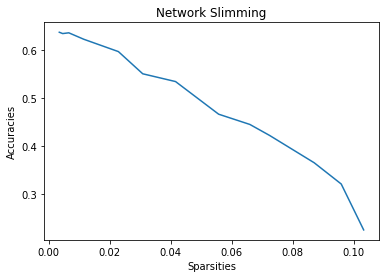

In [22]:
plt.plot(spars, accs)
plt.xlabel('Sparsities')
plt.ylabel('Accuracies')
plt.title('Network Slimming')

In [23]:
np.savetxt('ns_accuracies.csv', accs, delimiter=',')
np.savetxt('ns_sparsities.csv', spars, delimiter=',')

# Pick Best Model

In [25]:
def score(acc, sparsity):

    return (acc + sparsity) / 2

In [26]:
# get model with best score
all_models.sort(key=lambda m: score(m[2][1], m[3]))

# final network without BatchNorm
best_model = all_models[-1][1]

In [27]:
print(best_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 25, 25, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 25, 25, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 11, 11, 32)        0         
                                                      

In [28]:
results = best_model.evaluate(val_images, val_labels, batch_size=128)
final_score = score(all_models[-1][2][1], all_models[-1][3])

print('threshold:', all_models[-1][0])
print('results: ', all_models[-1][2])
print('sparsity: ', all_models[-1][3])
print('final_score', final_score)

best_model.save_weights('my_model_weights_3.h5')

20/20 [==============================] - 0s 7ms/step - loss: 1.6018 - accuracy: 0.2246
threshold: 0.9400000000000001
results:  [0.957817554473877, 0.6360396146774292]
sparsity:  0.006611202277491723
final_score 0.32132540847746044
